In [77]:
import os, subprocess
import json
import uproot
import awkward as ak
import numpy as np
from coffea import processor, util, hist

%matplotlib inline
import matplotlib.pyplot as plt
from cycler import cycler

In [78]:
colors = {}
colors['QCD'] = '#1f77b4'
colors['VBF'] = '#ff7f0e'
colors['VV'] = '#2ca02c'
colors['Wjets'] = '#d62728'
colors['WH'] = '#9467bd'
colors['Zjets'] = '#8c564b'
colors['ZH'] = '#e377c2'
colors['ggF'] = '#7f7f7f'
colors['ttbar'] = '#bcdb22'
colors['singlet'] = '#bcdb22'
colors['ttH'] = '#17becf'

In [79]:
lumis = {}
lumis['2016'] = 35.9
lumis['2017'] = 41.5
lumis['2018'] = 59.9

nfiles_mc = {}
nfiles_mc['2016'] = 64
nfiles_mc['2017'] = 89
nfiles_mc['2018'] = 106

with open('xsec.json') as f:
  xs = json.load(f)

with open('pmap.json') as f:
  pmap = json.load(f)

In [80]:
year = '2016'
outsum = processor.dict_accumulator()

In [81]:
# Higgs mass window
mbb_min = 110
mbb_max = 138

In [82]:
def significance(s,b):
    if b==0:
        return 0
    z_squared = 2.0*(s+b)*np.log(1.0+1.0*s/b) - 2.0*s
    return np.sqrt(z_squared)

In [83]:
def yield_plot(sr, name):
    
    nggF_sel = sr[('ggF',)]
    nVBF_sel = sr[('VBF',)]
    nWH_sel = sr[('WH',)]
    nZH_sel = sr[('ZH',)]
    nttH_sel = sr[('ttH',)]
    
    nQCD_sel = sr[('QCD',)]
    nVV_sel = sr[('VV'),]
    nWjets_sel = sr[('Wjets',)]
    nZjets_sel = sr[('Zjets',)]
    nttbar_sel = sr[('ttbar',)]
    nst_sel = sr[('singlet',)]

    sr_name = name+'-like'
    categories = [sr_name]
    
    yields = {}
    yields['ttH'] = [nttH_sel]
    yields['ZH'] = [nZH_sel]
    yields['WH'] = [nWH_sel]
    yields['VBF'] = [nVBF_sel]
    yields['ggF'] = [nggF_sel]
               
    yields['VV'] = [nVV_sel]
    yields['ttbar'] = [nttbar_sel]
    yields['singlet'] = [nst_sel]
    yields['Wjets'] = [nWjets_sel]
    yields['Zjets'] = [nZjets_sel]
    yields['QCD'] = [nQCD_sel]
    
    with open(year+'/plot-all/'+name+'_yield.json', 'w') as outfile:
        json.dump(yields, outfile)
    
    print(yields)
    
    y = [0]
    for p in ['ttH','ZH','WH','VBF','ggF','VV','Wjets','Zjets','QCD','ttbar','singlet']:
        bars = y
        if p == 'ttH':
            plt.bar(categories, yields[p], width=1, color=colors[p], label=p)
        else:
            plt.bar(categories, yields[p], width=1, color=colors[p], bottom=bars, label=p)
            
        y = [y[0]+yields[p][0]]

    plt.ylabel('Events')
    plt.yscale('log')
    plt.ylim(0.1,100000)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    png_name = year+'/plot-all/'+name+'_yield.png'
    plt.savefig(png_name,bbox_inches='tight')
    
    pdf_name = year+'/plot-all/'+name+'_yield.pdf'
    plt.savefig(pdf_name,bbox_inches='tight')

In [84]:
def plot_overlay(x,name):
    x.label = 'Events'
    axes = hist.plotgrid(x, overlay='process', line_opts={}, order=['QCD','Zjets','Wjets','ttbar','singlet','VV','ggF','VBF','WH','ZH','ttH'])
    axes[0, 0].set_prop_cycle(cycler(color=colors.values()))
    axes[0, 0].set_yscale('log')
    axes[0, 0].set_ylim(.001, 100000)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    png_name = year+'/plot-all/'+name+'.png'
    plt.savefig(png_name,bbox_inches='tight')
    pdf_name = year+'/plot-all/'+name+'.pdf'
    plt.savefig(pdf_name,bbox_inches='tight')

In [85]:
def plot_stack(x,name):
    x.label = 'Events'
    axes = hist.plot1d(x, overlay='process', fill_opts={'edgecolor': (0,0,0,1)}, stack=True, order=['ttH','ZH','WH','VBF','ggF','VV','ttbar','singlet','Wjets','Zjets','QCD'])
    axes.set_prop_cycle(cycler(color=colors.values()))
    axes.set_yscale('log')
    axes.set_ylim(.001, 100000)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    png_name = year+'/plot-all/'+name+'_stack.png'
    plt.savefig(png_name,bbox_inches='tight')
    pdf_name = year+'/plot-all/'+name+'_stack.pdf'
    plt.savefig(pdf_name,bbox_inches='tight')

In [86]:
# Load all MC
for n in range(1,nfiles_mc[year]+1):
    print(n)
    filename = 'condor/outfiles/'+year+'_'+str(n)+'.coffea'
    if os.path.isfile(filename):
        out = util.load(filename)
        outsum.add(out)
    else:
        print("File " + filename + " is missing")
        
scale_lumi = {k: xs[k] * 1000 *lumis[year] / w for k, w in outsum['sumw'].items()}
outsum['templates2'].scale(scale_lumi, 'dataset')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64


In [87]:
templates = outsum['templates2'].group('dataset', hist.Cat('process', 'Process'), pmap).integrate('region', 'signal').integrate('ddb1',int_range=slice(0.89,1))

/uscms/home/jennetd/.local/lib/python3.6/site-packages/coffea/hist/hist_tools.py:346: RuntimeWarning: Not all requested indices present in <Cat (name=dataset) instance at 0x7fc1dad6c518>
  warnings.warn("Not all requested indices present in %r" % self, RuntimeWarning)


In [88]:
x = templates.sum('mjj','qgl1','qgl2','msd1')

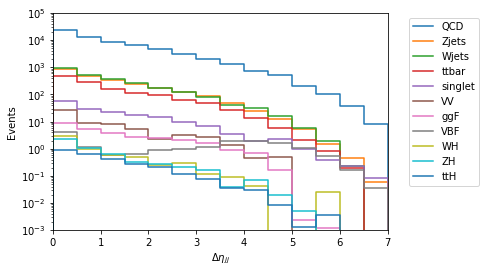

In [89]:
plot_overlay(x,'deta')

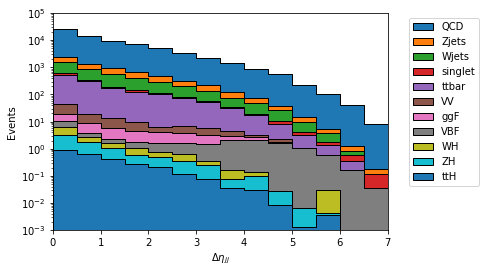

In [90]:
plot_stack(x,'deta')

In [91]:
x = templates.sum('deta','qgl1','qgl2','msd1')

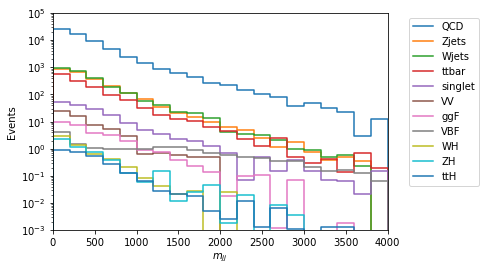

In [92]:
plot_overlay(x,'mjj')

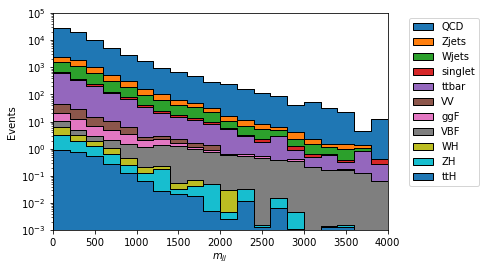

In [93]:
plot_stack(x,'mjj')

In [94]:
x = templates.sum('deta','mjj','qgl2','msd1')

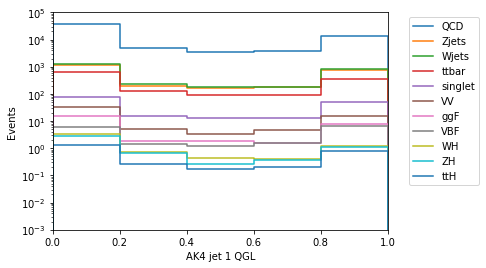

In [95]:
plot_overlay(x,'qgl1')

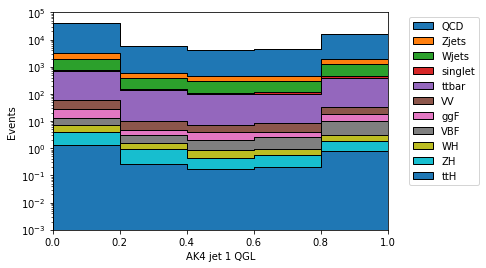

In [96]:
plot_stack(x,'qgl1')

In [97]:
x = templates.sum('deta','mjj','qgl1','msd1')

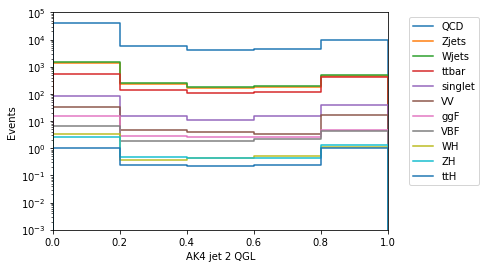

In [98]:
plot_overlay(x,'qgl2')

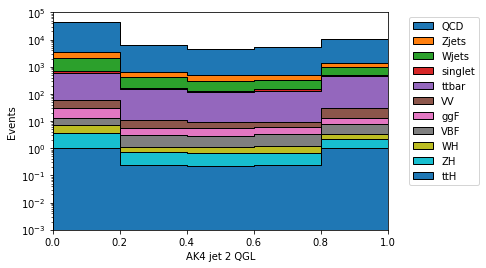

In [99]:
plot_stack(x,'qgl2')

In [100]:
templates_window=templates.sum('qgl1','qgl2').integrate('msd1',int_range=slice(mbb_min,mbb_max))

In [101]:
if year == '2017':

    cuts = []
    sigs = []

    deta_slices = [i*0.5 for i in range(0,14)]
    mjj_slices = [i*200 for i in range(0,20)]

    for deta in deta_slices:
        for mjj in mjj_slices:
            sliced = templates_window.integrate('deta',int_range=slice(deta,7)).integrate('mjj',int_range=slice(mjj,4000))
            s = sliced.values()[('VBF',)]
            b = sliced.values()[('ggF',)] + sliced.values()[('ZH',)] + sliced.values()[('WH',)] + sliced.values()[('ttH',)] 
            b += sliced.values()[('QCD',)] + sliced.values()[('Wjets',)] + sliced.values()[('Zjets',)] + sliced.values()[('VV',)] + sliced.values()[('ttbar',)] + sliced.values()[('singlet',)]
            
            sigs += [significance(s,b)]
            cuts += [[mjj, deta]]
        
    cuts = np.array(cuts)
    print(max(sigs))
    print(cuts[np.argmax(sigs)])
    mjj_cut = cuts[np.argmax(sigs)][0]
    deta_cut = cuts[np.argmax(sigs)][1]

    plt.hist2d(cuts[:,0], cuts[:,1], density=False, weights=sigs, bins=[20,14]);
    plt.xlabel('$m_{jj}$');
    plt.ylabel('$\Delta\eta_{jj}$');
    plt.savefig(year+'/plot-all/vbfsigs_2d.png')
    
else:
    mjj_cut = 1000.
    deta_cut = 3.5

{'ttH': [0.046431429251362386], 'ZH': [0.10058376560442489], 'WH': [0.09267355895794827], 'VBF': [5.574014262866918], 'ggF': [1.1506001557191434], 'VV': [0.0], 'ttbar': [12.011375160611502], 'singlet': [2.090169465335643], 'Wjets': [2.2391820336153314], 'Zjets': [3.235408477773844], 'QCD': [504.47070335940117]}


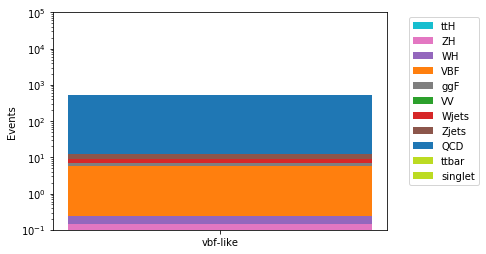

In [102]:
sr = templates_window.integrate('deta',int_range=slice(deta_cut,7)).integrate('mjj',int_range=slice(mjj_cut,4000)).values()
yield_plot(sr, 'vbf')

In [103]:
# VBF significance
s = sr[('VBF',)] 
b = sr[('QCD',)] + sr[('Zjets',)] + sr[('Wjets',)] + sr[('VV',)] + sr[('ttbar',)] +sr[('singlet',)] + sr[('ggF',)] + sr[('WH',)] + sr[('ZH',)] + sr[('ttH',)]

print(significance(s,b))
# this only makes sense in the mass window of Higgs

0.2427406669154075


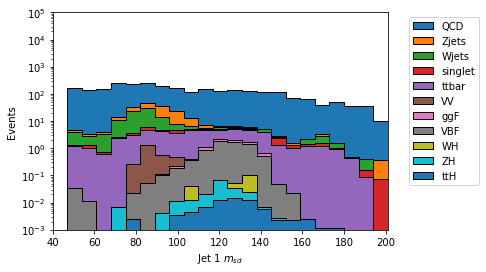

In [104]:
mhist = templates.sum('qgl1','qgl2').integrate('deta',int_range=slice(deta_cut,7)).integrate('mjj',int_range=slice(mjj_cut,4000))
plot_stack(mhist,'vbf-msd1')

In [105]:
templates_cutflow = outsum['templates2'].group('dataset', hist.Cat('process', 'Process'), pmap).integrate('region', 'signal').sum('qgl1','qgl2')

/uscms/home/jennetd/.local/lib/python3.6/site-packages/coffea/hist/hist_tools.py:346: RuntimeWarning: Not all requested indices present in <Cat (name=dataset) instance at 0x7fc1dad6c518>
  warnings.warn("Not all requested indices present in %r" % self, RuntimeWarning)


In [106]:
import pandas as pd

In [107]:
df1 = pd.DataFrame(index=['$\Delta\eta_{jj}$','$m_{jj}$','DeepDoubleB'],columns=['ggF','VBF','WH','ZH','ttH'])
df2 = pd.DataFrame(index=['$\Delta\eta_{jj}$','$m_{jj}$','DeepDoubleB'],columns=['QCD','Wjets','Zjets','VV','ttbar','singlet'])

In [108]:
# deta cut
tmp = templates_cutflow.sum('msd1','mjj','ddb1').integrate('deta',int_range=slice(deta_cut,7)).values()
cutname = '$\Delta\eta_{jj}$'

df1['ggF'][cutname] = tmp[('ggF'),]
df1['VBF'][cutname] = tmp[('VBF'),]
df1['WH'][cutname] = tmp[('WH'),]
df1['ZH'][cutname] = tmp[('ZH'),]
df1['ttH'][cutname] = tmp[('ttH'),]

df2['QCD'][cutname] = tmp[('QCD'),]
df2['Wjets'][cutname] = tmp[('Wjets'),]
df2['Zjets'][cutname] = tmp[('Zjets'),]
df2['VV'][cutname] = tmp[('VV'),]
df2['ttbar'][cutname] = tmp[('ttbar'),]
df2['singlet'][cutname] = tmp[('singlet'),]

In [109]:
# mjj cut
tmp = templates_cutflow.sum('msd1','ddb1').integrate('deta',int_range=slice(deta_cut,7)).integrate('mjj',int_range=slice(mjj_cut,4000)).values()
cutname = '$m_{jj}$'

df1['ggF'][cutname] = tmp[('ggF'),]
df1['VBF'][cutname] = tmp[('VBF'),]
df1['WH'][cutname] = tmp[('WH'),]
df1['ZH'][cutname] = tmp[('ZH'),]
df1['ttH'][cutname] = tmp[('ttH'),]

df2['QCD'][cutname] = tmp[('QCD'),]
df2['Wjets'][cutname] = tmp[('Wjets'),]
df2['Zjets'][cutname] = tmp[('Zjets'),]
df2['VV'][cutname] = tmp[('VV'),]
df2['ttbar'][cutname] = tmp[('ttbar'),]
df2['singlet'][cutname] = tmp[('singlet'),]

In [110]:
#ddb cut
tmp = templates_cutflow.sum('msd1').integrate('deta',int_range=slice(deta_cut,7)).integrate('mjj',int_range=slice(mjj_cut,4000)).integrate('ddb1',int_range=slice(0.89,1)).values()
cutname = 'DeepDoubleB'

df1['ggF'][cutname] = tmp[('ggF'),]
df1['VBF'][cutname] = tmp[('VBF'),]
df1['WH'][cutname] = tmp[('WH'),]
df1['ZH'][cutname] = tmp[('ZH'),]
df1['ttH'][cutname] = tmp[('ttH'),]

df2['QCD'][cutname] = tmp[('QCD'),]
df2['Wjets'][cutname] = tmp[('Wjets'),]
df2['Zjets'][cutname] = tmp[('Zjets'),]
df2['VV'][cutname] = tmp[('VV'),]
df2['ttbar'][cutname] = tmp[('ttbar'),]
df2['singlet'][cutname] = tmp[('singlet'),]

In [111]:
print(df1)
df1 = df1.astype('int')
df1.to_latex(buf=year+'/cutflow-sig.tex')

                       ggF      VBF        WH        ZH        ttH
$\Delta\eta_{jj}$  3.06822  12.9332  0.449236  0.458831   0.313433
$m_{jj}$           2.46839   12.332  0.360866  0.386718   0.277366
DeepDoubleB        1.32953  6.89172  0.121203   0.13017  0.0726312


In [112]:
print(df2)
df2 = df2.astype('int')
df2.to_latex(buf=year+'/cutflow-bkg.tex')

                       QCD    Wjets    Zjets       VV    ttbar  singlet
$\Delta\eta_{jj}$   178024  4373.61  1347.85  54.9636  479.429  128.907
$m_{jj}$            146708  3579.05  1099.45  44.4077  417.898  110.128
DeepDoubleB        2496.23  79.7486  77.2681  2.18708  44.3879  8.59264


In [113]:
# Hard-coded -- combine results from all 3 years

tot_H = 0
VBF = 0

# 2016
tot_H += 1.32953 + 6.89172 + 0.121203 + 0.13017 + 0.0726312
VBF += 6.89172

# 2017
tot_H += 2.34718 + 8.93221 + 0.14979 + 0.0479135 + 0.083451
VBF += 8.93221

# 2018
tot_H += 2.94965 + 11.1321 + 0.18686 + 0.156234 + 0.100007
VBF += 11.1321

print(VBF/tot_H)

0.7783864938577805


In [114]:
np.sqrt(0.243**2 + 0.356**2 +  0.323**2)

0.5386223166561148